# Compare original median filter with normalized median filter.
Once a velocity field has been obtained from a PIV processor, there might be vectors that, visually, look as outliers. One way to get rid of them is to apply a median filter: compare every velocity vector to the average vector in its, say, 3x3 neighborhoud and, if it is bigger than a threshold, replace it with the average vector.

As described in Adrain & Westerweel, "Particle image velocimetry", 2011, J. Westerweel and coauthors created two versions of the median filter. The original one was created in 1994. Its main disadvantage is that it uses one (global) threshold for all the vectors in the velocity field. In 2005, it was proposed to normalize every vector in the velocity field before comparing it to the global threshold, thereby mitigating the disadvantage of the 1994 version of the median filter (see J. Westerweel, F. Scarano, "Universal outlier detection for PIV data", Experiments in fluids, 39(6), p.1096-1100, 2005).

OpenPIV has implemented both versions of the filter. The 1994 version (the original version) is given by the function `validation.local_median_val()`. The 2005 version (the normalized version) is given by the function `validation.local_norm_median_val()`.

The phylosophy of their usage is the following. Both filters just check every vector in the velocity field and create a "mask" of the velocity field where those vectors that didn't pass the threshold requirement are marked as NaNs. Then the OpenPIV function `filters.replace_outliers()` must be implemented. That function reads the "mask" and replace every NaN vector with the average of its neighbourhood.

The purpose of this tutorial is to compare the two fitlers for a rather difficult case of PIV of a two-phase cap-bubbly air-water upward flow.

In [7]:
import cv2 # conda install opencv; alternatively use imread() from openpiv tools
import numpy as np
import matplotlib.pyplot as plt
from openpiv import tools, pyprocess, preprocess, validation, filters, scaling

Now let's write a function that does basic PIV processing on a pair of PIV frames. The function will calculate correlations with `pyprocess.fft_correlate_images()`, then it will convert correlations to displacements with `pyprocess.correlation_to_displacement` and, finally, it will validate the velocity field and replace the outliers. It is very imporatant to understand what the right strategy is for the validation and replacement of the outliers. There are two types of validation: validation of the correlations and validation of the velocity field. Validation of the correlations makes sure that the largest correlation peak is much bigger than the rest of the peaks, thereby making sure that the largest correlation peak is not just noice but a valid signal. Once the correlations have been validated this way, one goes ahead and calculates the velocity field. Surprisingly, one can, still, obtain a velocity field with outliers (some vectors are much bigger or point in the direction different than the vectors surrounding it). I.e., correlations validation doesn't give a 100% warranty that the resultant velocity field will be absolutely accurate. So, one goes ahead and validates the velocity field with a median filter which compares every vector to several of its surrounding vectors. Both validation types just mark the invalid vectors. Then the replacement function goes through all the marked vectors and replaces every one of them with the average of its surrounding vectors. Now imagine if the majority of the vectors have been marked as invalid. In this case, the chance of getting invalid vectors in the surroundings of other invalid vectors is big. And we end up with completely "remodeled" velocity field where almost every vector has been replaced with the average of its surroundings. I.e., the resultant field is not physical. Obviously, if you choose to do both validations types (which, very well, can be the case), then you have invalid vectors due to correlations and due to outliers. Of course, some of them may be the same, but some of them may not. I.e., you increasing the number of invalid vectors for further replacement procedure. You want to avoid it. In order to avoid it, do validation-replacement in steps. First, validate correlations and replace them at once. Second, validate outliers and replace them at once.

In [8]:
def PIVanalysis(dataArray, 
                imageShape, 
                searchAreaSize,
                overlap,
                scalingFactor,
                deltaT,
                maskBubble,
                nameTXT,
                medianTest,
                numRuns,
                onImg = None,
                s2nThresh = 0.8                
               ):
    
    """
    The procedure is adapted from ensemble_correlation.ipynb OpenPIV tutorial.
    Parameters: dataArray (numpy array) - an array of PIV images that contains only
                                          one PIV pair, its structure is
                                          dataArray = np.asarray([frameA, frameB])
                onImg (cv2.imread) - an image to plot the velocity fields on 
                searchAreaSize (int) - is the size of the interrogation window on frameB;
                                       it can be a bit bigger, which, reportedly, is better
                                       for PIV pair with high dynamic range (like in our
                                       case, where velocities in the bubble wake are much
                                       bigger than velocities closer to the walls of the test section -
                                       the range of velocities (i.e., dynamic range) is big)
                maskBubble (numpy array) - a binary image where bubbles are white and background is
                                           black; is used to mask out bubbles
                deltaT (float) - s, the time between the two PIV frames
                scalingFactor (float) - pix/mm, scaling factor
                nameTXT (str) - .txt, the name of the file to save the resultant OpenPIV velocity field
                medianTest (int) - can be either 1994 or 2005; 1994 refers to original Westerweel's
                                   median test given by the function validation.local_median_val(),
                                   2005 refers to the normalized Westerweel's median test given by the
                                   function validation.local_norm_median_val()
                numRuns (int) - can be 1 or 2; the number of times to run the normalized median filter
    Returns: None
    """
    # Mask out the bubbles.
    dataArray[0] = cv2.bitwise_and(dataArray[0], dataArray[0], mask=cv2.bitwise_not(maskBubble))
    dataArray[1] = cv2.bitwise_and(dataArray[1], dataArray[1], mask=cv2.bitwise_not(maskBubble))

    # Find the correlations map.
    # "linear" correlation_method together with normalized_correlation=True
    # helps to boost the s2n threshold from 1.003 to 2 for 95% valid vectors.
    # See OpenPIV Jupiter notebook compare_correlations_algorithms.ipynb for 
    # why correlation_method is chosen to be 'linear'.
    corrs = pyprocess.fft_correlate_images(
        pyprocess.moving_window_array(dataArray[0],searchAreaSize,overlap),
        pyprocess.moving_window_array(dataArray[1],searchAreaSize,overlap),
        normalized_correlation=True,
        correlation_method="linear"
    )
    
    mesh = pyprocess.get_field_shape(imageShape,
                                     search_area_size = searchAreaSize,
                                     overlap = overlap
    )

    nrows, ncols = mesh[0], mesh[1]
    
    # Having found correlations, we can find corresponding displacements in pix.
    # IMPOTANT: OpenPIV uses u and v for displacements as well as for velocities in
    # Since that's confusing, we are going to use xDisp and yDisp for 
    # displacements and u and v for velocities.
    xDisp, yDisp = pyprocess.correlation_to_displacement(corrs, nrows, ncols)

    # Having found displacements in pix, we can find corresponding velocities in
    # pix/time
    u = xDisp/deltaT # pix/s
    v = yDisp/deltaT # pix/s

    x, y = pyprocess.get_coordinates(imageShape,
                                     search_area_size = searchAreaSize,
                                     overlap = overlap
    )

    # Mask out the areas without the flow right now (bubbles).
    grid_mask = preprocess.prepare_mask_on_grid(x, y, maskBubble[:,::-1])
    masked_u = np.ma.masked_array(u, mask=grid_mask)
    masked_v = np.ma.masked_array(v, mask=grid_mask)

    uShape = (masked_u.T).shape

    # Now let's do validation. Pay attention, that validation doesn't mean automatic
    # replacement of the outliers, it means that we are going to detect the outliers
    # and mark them as outliers. Their replacement is a separate procedure and will
    # be done next.

    # Do the validation of the correlation peaks.
    corrs = corrs.astype('float64')
    s2n = pyprocess.sig2noise_ratio(corrs, "peak2mean")
    invalid_mask_s2n = validation.sig2noise_val(s2n, threshold = s2nThresh)
    # Now we can replace outliers flagged by the invalid_mask_s2n.
    masked_u, masked_v = filters.replace_outliers(masked_u.flatten(), masked_v.flatten(),
                                                  invalid_mask_s2n,
                                                  method = 'localmean',
                                                  max_iter = 3, 
                                                  kernel_size = 17 
    ) # IMPORTANT to flatten u and v
    
    # Do the validation based on the median test (as described in the 
    # German PIV book on p.185). We can do it in two ways. First - use
    # the original Westerweel's median test as implemented in OpenPIV's 
    # function validation.local_median_val. Second - use the improved (normalized)
    # Westerweel's median test which is implemented in OpenPIV's function
    # validation.local_norm_median_val.
    # The problem is that  filters.replace_outliers() returned flattened arrays on
    # the previous step. But both validation.local_median_val() and 
    # validation.local_norm_median_val() require 2D arrays as the input. The way to
    # transfrom the flattened arrays to the 2D arrays is the following:
    masked_u = np.reshape(masked_u,(uShape[0],uShape[1])) # a 2D array
    masked_v = np.reshape(masked_v,(uShape[0],uShape[1])) # a 2D array
    if medianTest == 1994:
        # ORIGINAL WESTERWEEL'S MEDIAN TEST.
        invalid_mask_median = validation.local_median_val(masked_u, 
                                                          masked_v,
                                                          u_threshold=4000, # abs difference with the mean
                                                          v_threshold=4000, # abs difference with the mean
                                                          size=2 # e.g., size=2 is a 5x5 kernel
        )
        # Now we can replace outliers flagged by the invalid_mask_median.        
        masked_u, masked_v = filters.replace_outliers(masked_u.flatten(), masked_v.flatten(),
                                                      invalid_mask_median.flatten(),
                                                      method = 'localmean',
                                                      max_iter = 5, 
                                                      kernel_size = 2  
        ) # IMPORTANT to flatten u and v
    elif medianTest == 2005:
        # NORMALIZED WESTERWEEL'S MEDIAN TEST.
        # One doesn't have to restrict oneself to just one instance of the median test.
        # For this particular dataset, after an extensive test of different parameters, it
        # was concluded that two median tests are necessary. The reason for that was the following.
        # The velocity field had a lot of very obvious outliers close to each other. Yet it also
        # had less obvious outliers sitting far away from each other. The first median filter uses a
        # bigger kernel size which is bigger than the width of the set of the neighbouring outliers.
        # I.e., if I have 5 outliers in a row, I want my kernels size to be bigger than 5 because, in 
        # this case, valid vectors will be included into the averaging procedure. If the kernel is less
        # than 5, it will include only the outliers into the averaging procedure resulting in no good.
        # I.e., we will be compare the outlier to the average of the outliers around it, therefore we
        # will not detect it as the outlier because, obviously, it will be on the order of the average of
        # the outliers.
        # At the second step, when we are left with only less obvious outliers which are sittig far away
        # from each other, we're doing median filter with the smallest kernel size possible. Since the 
        # outliers are less obvious, they can be barealy visually distinguishable from other vectors. 
        # That is why the kernel size must be so small: it compares the outlier only to its immediate 
        # neighbours and detects it as an outlier. If it compared the outlier to more vectors, the chance
        # that more vectors make the average of them bigger is high. And since we compare the outlier to
        # the average of the surrounding vectors, we might not detect it as an outlier. That's why we
        # we want the smallest kernel size in this case.

        # Do the first run of the median test. 
        invalid_mask_median1 = validation.local_norm_median_val(masked_u,
                                                                masked_v,
                                                                ε = 0.2,
                                                                threshold = 2.5,
                                                                size = 2
        )
        # Now we can replace outliers flagged by the invalid_mask_median1.        
        masked_u, masked_v = filters.replace_outliers(masked_u.flatten(), masked_v.flatten(),
                                                      invalid_mask_median1.flatten(),
                                                      method = 'localmean',
                                                      max_iter = 5, 
                                                      kernel_size = 2 
        ) # IMPORTANT to flatten u and v
        invalid_mask_median = invalid_mask_median1

        if numRuns == 2:
            # Do the second run of the median test.
            # Start with reshaping masked_u and masked_v to 2D arrays.
            masked_u = np.reshape(masked_u,(uShape[0],uShape[1])) # a 2D array
            masked_v = np.reshape(masked_v,(uShape[0],uShape[1])) # a 2D array
            invalid_mask_median2 = validation.local_norm_median_val(masked_u,
                                                                    masked_v,
                                                                    ε = 0.2,
                                                                    threshold = 2.5,
                                                                    size = 1
            )
            masked_u, masked_v = filters.replace_outliers(masked_u.flatten(), masked_v.flatten(),
                                                          invalid_mask_median2.flatten(),
                                                          method = 'localmean',
                                                          max_iter = 5, 
                                                          kernel_size = 1 
            ) # IMPORTANT to flatten u and v

            # When we will be saving the results into the OpenPIV .txt file, we will want to
            # know about all the invalid vectors. That's why we are combining the masks.
            # The way they are combined is copied from the code for OpenPIV.validation.typical_validation
            # line 295. These are, actually, flags, not masks.
            invalid_mask_median = invalid_mask_median1 | invalid_mask_median2

    # When we will be saving the results into the OpenPIV .txt file, we will want to
    # know about all the invalid vectors. That's why we are combining the masks.
    # The way they are combined is copied from the code for OpenPIV.validation.typical_validation
    # line 295. These are, actually, flags, not masks.
    invalid_mask = invalid_mask_s2n | invalid_mask_median.flatten()

    x, y, masked_u, masked_v = scaling.uniform(x, y, masked_u, masked_v, scaling_factor = scalingFactor)

    # MASK OUT VELOCITY FIELD.
    # Before saving the field to a .txt file, give zeros to those vectors that lie in the masked regions.
    # Right now, x and y are in the image system of coordinates: x is to the right, y is downwards, (0,0)
    # is in the top left corner. It can be learnt from the GitHub code of tools.transform_coordinates.
    # Since our x and y are in mm, we're going to use scaling factor to convert them to pix. Then we're going
    # to use them to identify whether or not their place on an example masked image is masked.
    xFlat = x.flatten()
    yFlat = y.flatten()
    for i in range(xFlat.size):
        if maskBubble[int(yFlat[i]*scalingFactor), int(xFlat[i]*scalingFactor)] == 255:
                masked_u[i] = 0
                masked_v[i] = 0
    
    x, y, masked_u, masked_v = tools.transform_coordinates(x, y, masked_u, masked_v)

    tools.save(nameTXT, x, y, masked_u, masked_v, invalid_mask)
    
    # Calculate the percentage of the invalid vectors due to median validation.
    invMedOutPer = (np.count_nonzero(invalid_mask_median) / invalid_mask_median.size) * 100 # percent of the invalid vectors
    # Calculate the percentage of the invalid vectors due to sig2noise validation.
    invSnrOutPer = (np.count_nonzero(invalid_mask_s2n) / invalid_mask_s2n.size) * 100 # percent of the invalid vectors
    # Calculate the percentage of the invalid vectors due to both median and sig2noise validations.
    invOutPer = (np.count_nonzero(invalid_mask) / invalid_mask.size) * 100 # percent of the invalid vectors
    print("\nPercentage of invalid vectors:\ninvalidMedianOutliersPercent={:.2f},\ninvalidS2NOutliersPercent={:.2f},\ninvalitOutliersPercent={:.2f}".format(invMedOutPer,invSnrOutPer,invOutPer))
    print("\nThe resultant velocity field (red are vectors that were validated as outliers\nand replaced with the average of their neighbouring vectors):")
    figure, _ = tools.display_vector_field(filename = str(nameTXT),
                                           scaling_factor = scalingFactor,
                                           scale = 3500,
                                           on_img = True,
                                           show_invalid = True,
                                           image_name = onImg
    )
    plt.show()

In [9]:
# Global variables
tPulse = 0.0015 # s - time between frame A and frame B
ol = 16 # overlap: give it in pix, not %
interW = 32 # the size of the interrogation window
searchAS = np.round(1.1*interW).astype(np.uint32) # the size of the interrogation window in frameB 
sf = 1/0.052 # pix/mm scaling factor

# The name of the OpenPIV txt file to save the results to.
fileTXT = '../test21/bubblesOpenPIVtxtFile.txt'

# The file names of PIV frames and bubbles mask.
frameA = '../test21/bubblesFrameA.png'
frameB = '../test21/bubblesFrameB.png'
bubblesMaskFile = '../test21/bubblesMask.png'

pairPIV = np.asarray([cv2.imread(frameA,0), cv2.imread(frameB,0)]) # 0 flag means read as gray scale
bubblesMask = cv2.imread(bubblesMaskFile,0) # 0 flag means read as gray scale
imageShape = pairPIV[0].shape

Using original 1994 Westerweel's median filter:


Percentage of invalid vectors:
invalidMedianOutliersPercent=8.22,
invalidS2NOutliersPercent=5.03,
invalitOutliersPercent=13.25

The resultant velocity field (red are vectors that were validated as outliers
and replaced with the average of their neighbouring vectors):


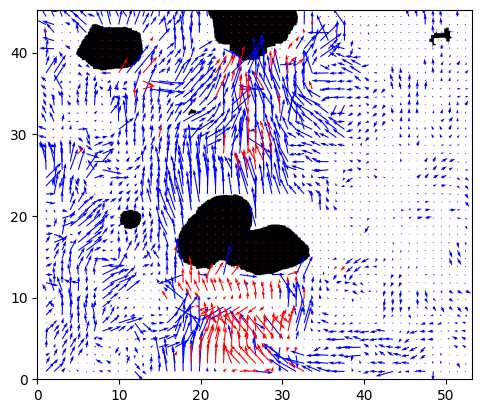

In [10]:
print("Using original 1994 Westerweel's median filter:\n")
PIVanalysis(dataArray = pairPIV, 
            imageShape = imageShape, 
            searchAreaSize = searchAS,
            overlap = ol,
            scalingFactor = sf,
            deltaT = tPulse,
            maskBubble = bubblesMask,
            nameTXT = fileTXT,
            medianTest = 1994,
            numRuns = 1,
            s2nThresh = 2, 
            onImg = bubblesMaskFile                 
)

Using normalized 2005 Westerweel's median filter with one run:


Percentage of invalid vectors:
invalidMedianOutliersPercent=32.96,
invalidS2NOutliersPercent=5.03,
invalitOutliersPercent=37.90

The resultant velocity field (red are vectors that were validated as outliers
and replaced with the average of their neighbouring vectors):


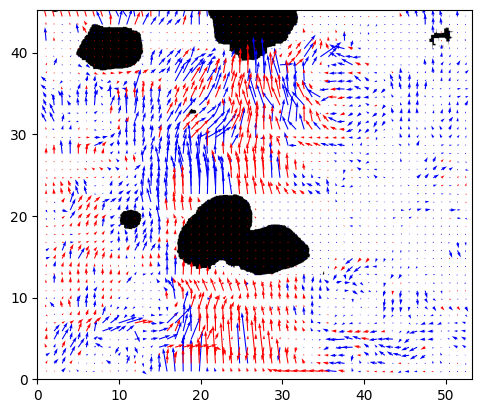

In [11]:
print("Using normalized 2005 Westerweel's median filter with one run:\n")
PIVanalysis(dataArray = pairPIV, 
            imageShape = imageShape, 
            searchAreaSize = searchAS,
            overlap = ol,
            scalingFactor = sf,
            deltaT = tPulse,
            maskBubble = bubblesMask,
            nameTXT = fileTXT,
            medianTest = 2005,
            numRuns = 1,
            s2nThresh = 2, 
            onImg = bubblesMaskFile                 
)

Using normalized 2005 Westerweel's median filter with two runs:


Percentage of invalid vectors:
invalidMedianOutliersPercent=55.26,
invalidS2NOutliersPercent=5.03,
invalitOutliersPercent=59.37

The resultant velocity field (red are vectors that were validated as outliers
and replaced with the average of their neighbouring vectors):


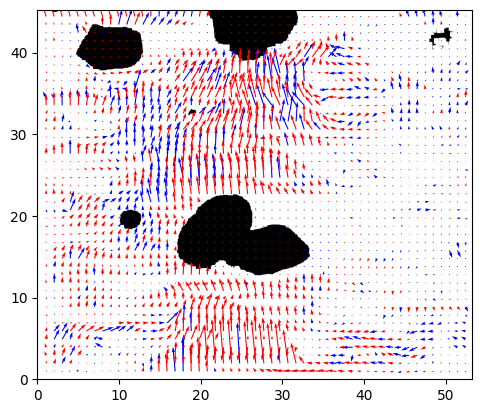

In [12]:
print("Using normalized 2005 Westerweel's median filter with two runs:\n")
PIVanalysis(dataArray = pairPIV, 
            imageShape = imageShape, 
            searchAreaSize = searchAS,
            overlap = ol,
            scalingFactor = sf,
            deltaT = tPulse,
            maskBubble = bubblesMask,
            nameTXT = fileTXT,
            medianTest = 2005,
            numRuns = 2,
            s2nThresh = 2, 
            onImg = bubblesMaskFile                 
)

See how the fields are becoming visually better starting from the classic median filter to the normalized median filter and to the double-ran normalized median filter. If one has several velocity fields in a row (i.e., the time series of velocity fields) and wants to average them (along the time axis), outliers might alter the average and one might need a bigger time series to get a more stable average. On the other hand when all the velocity fields don't have outliers, the average becomes more stable (doesn't need as big of a time series). Also, when one analyzes vortex dynamics (i.e., calculates different derivatives within a single velocity field), one should better have no outliers. This is why it is important to filter out the outliers and replace them with something better, like the average of the surrounding vectors.

### Final note.
The parameters used in the function `PIVanalysis()` were carefully selected using trials and errors method. The time it takes to find the right parameters can vary greatly: from a couple of hours to a day.

The filters have many parameters, changing some of them slightly can lead to drastic change in velocity fields. Therefore, one should spend time playing with the parameters in order got get the necessary experience. Go ahead and change the threshold parameter in either one of the normalized median filters runs from the current 2.5 to, say, 1.1 and witness with your own eyes how wrong the resultant velocity field becomes. This effect is explained at the beginning of this notebook.

Then go ahead and play with the rest of the parameters of all the filters as well as with the parameters of the outliers replacing functions. Also, try reordering the validation methods: try doing signal to noise validatin after the median filter and see how that affects the resultant velocity field.

This notebook examplifies the very basic PIV. Of course, for flows like this one more advanced PIV techniques are preferable, such as OpenPIV's `windef.py` which also has normalized median filter implemented.
